In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [2]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               871 non-null    object 
 1   SeasonNumber       871 non-null    int64  
 2   SeasonVersion      871 non-null    int64  
 3   Player             871 non-null    object 
 4   MatchId            871 non-null    object 
 5   Map                871 non-null    object 
 6   Category           871 non-null    object 
 7   Playlist           871 non-null    object 
 8   Input              871 non-null    object 
 9   Queue              871 non-null    object 
 10  PreCsr             871 non-null    int64  
 11  PostCsr            871 non-null    int64  
 12  Rank               871 non-null    int64  
 13  WasAtStart         871 non-null    int64  
 14  WasAtEnd           871 non-null    int64  
 15  WasInProgressJoin  871 non-null    int64  
 16  Mmr                2 non-n

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']

## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr', 'SeasonNumber', 'SeasonVersion'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               611 non-null    int64         
 1   Date                611 non-null    datetime64[ns]
 2   Map                 611 non-null    object        
 3   Category            611 non-null    object        
 4   Rank                611 non-null    int64         
 5   Outcome             611 non-null    int64         
 6   Accuracy            611 non-null    float64       
 7   DamageDone          611 non-null    int64         
 8   DamageTaken         611 non-null    int64         
 9   ShotsFired          611 non-null    int64         
 10  ShotsLanded         611 non-null    int64         
 11  ShotsMissed         611 non-null    int64         
 12  KD                  611 non-null    float64       
 13  KDA                 611 non-null    float64       

In [4]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,611.0,506.256956,211.549927,140.000000,323.500000,502.000000,697.500000,870.000000
Rank,611.0,3.959083,2.142458,1.000000,2.000000,4.000000,5.000000,8.000000
Outcome,611.0,0.554828,0.497392,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,611.0,51.962095,5.493716,24.390000,48.610000,52.080000,55.085000,80.560000
DamageDone,611.0,5230.140753,1850.057428,347.000000,3883.000000,5027.000000,6439.500000,12673.000000
DamageTaken,611.0,4459.306056,1563.761923,35.000000,3448.500000,4288.000000,5494.000000,9962.000000
ShotsFired,611.0,234.828151,80.307248,16.000000,179.500000,227.000000,291.000000,517.000000
ShotsLanded,611.0,121.600655,42.660316,4.000000,94.000000,116.000000,149.000000,286.000000
ShotsMissed,611.0,113.227496,41.045504,7.000000,84.000000,111.000000,139.500000,261.000000
KD,611.0,1.271408,0.763651,0.000000,0.855000,1.130000,1.450000,10.000000


In [5]:
# dfr.tail()
round(dfr.sort_values('Csr', ascending=False),2).head(8)

,index,Date,Map,Category,Rank,Outcome,Accuracy,DamageDone,DamageTaken,ShotsFired,...,LifetimeKD,LifetimeDmgRatio,LifetimeAcc,LifetimeBodyPct,LifetimeMeleePct,LifetimeHSPct,LifetimeGrenadePct,LifetimePowerPct,Csr,LifetimeWinRate
609,869,2024-03-14 01:38:39,Empyrean,CTF 3 Captures,3,1,63.64,1411,910,33,...,1.11,1.16,50.22,28.48,10.10,51.05,7.00,3.38,1105,0.56
606,866,2024-03-14 00:53:15,Live Fire,King of the Hill,1,1,63.01,3826,3956,146,...,1.11,1.16,50.20,28.50,10.09,51.04,7.01,3.37,1103,0.56
608,868,2024-03-14 01:23:44,Argyle,CTF 3 Captures,2,1,63.44,5697,4644,227,...,1.11,1.16,50.22,28.50,10.08,51.06,7.00,3.36,1099,0.56
605,865,2024-03-14 00:39:38,Streets,Oddball,3,1,58.17,6122,5287,251,...,1.11,1.16,50.19,28.48,10.09,51.05,7.01,3.37,1097,0.55
610,870,2024-03-14 01:42:56,Argyle,CTF 3 Captures,5,0,51.80,5886,7224,278,...,1.11,1.16,50.22,28.48,10.11,51.05,6.99,3.37,1093,0.55
607,867,2024-03-14 01:09:32,Streets,Oddball,8,0,56.62,5543,4668,219,...,1.11,1.16,50.20,28.48,10.09,51.06,7.01,3.37,1093,0.55
576,831,2024-03-08 01:52:40,Solitude,Slayer,4,1,40.71,2102,2790,140,...,1.12,1.17,50.02,28.33,10.06,51.10,7.04,3.46,1092,0.55
604,864,2024-03-12 02:26:23,Recharge,King of the Hill,2,1,57.48,7993,7000,294,...,1.11,1.16,50.18,28.47,10.09,51.06,7.01,3.38,1091,0.55


In [6]:
# dfr.hist(bins=15, figsize=(18, 14))
# plt.tight_layout()
# plt.show()

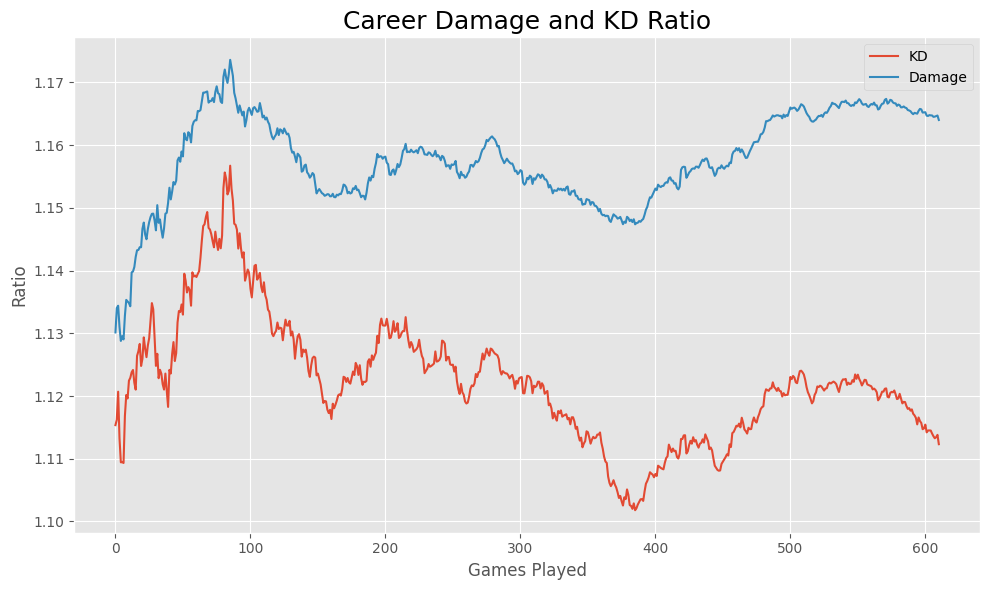

In [7]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Career Damage and KD Ratio', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/DamKD.png', dpi=300)
plt.show()

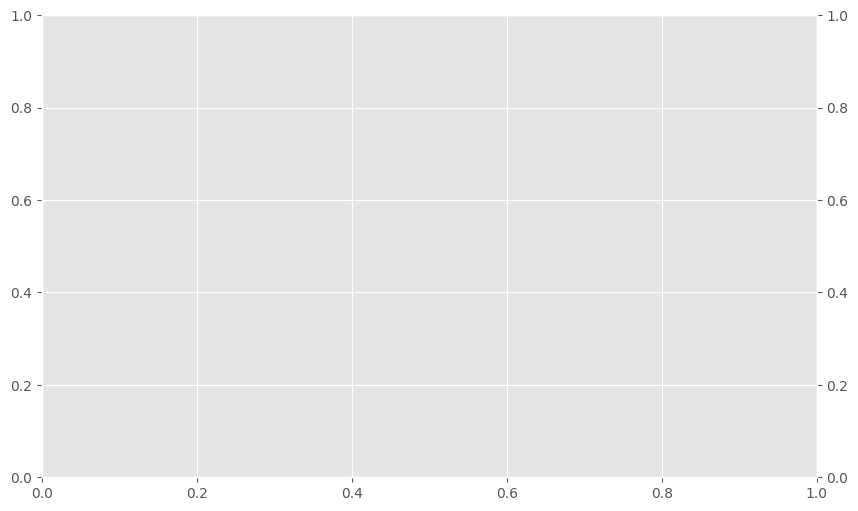

In [8]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams['animation.embed_limit'] = 300.0

dfr_date = dfr.index
dfr_kd = dfr['LifetimeKD']
dfr_dam = dfr['LifetimeDmgRatio']
dfr_csr = dfr['Csr']

# then assign df_date to x and df_close to y
x = dfr_date
y = dfr_kd
y2 = dfr_dam
y3 = dfr_csr

# calculate min and max x values + 1 and
# the min and max y values times scale factors
min_x = min(x)
max_x = max(x)
min_y = min(min(y), min(y2))
max_y = max(max(y), max(y2))
min_y3 = min(y3)
max_y3 = max(y3)

#########################################################################################
# generate and display animation line plot
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax2 = ax.twinx()

def animate(i):
    ax.cla() # clear the previous image
    ax2.cla()
    plt.title('KD/Damage Ratio and CSR over Time',fontsize=16)
    plt.xlabel('Game Played')
    plt.ylabel('Ratios/CSR')
    ax.plot(x[:i], y[:i], label='KD') # plot the line
    ax.plot(x[:i], y2[:i], label='Damage') # plot the line
    ax2.plot(x[:i], y3[:i], label='CSR', color='black')
    ax.set_xlim([0.99*min_x, 0.99*max_x]) # fix the x axis
    ax.set_ylim([0.99*min_y, 1.01*max_y]) # fix the y axis 
    ax2.set_xlim([0.99*min_x, 0.99*max_x])
    ax2.set_ylim(min_y3, 1.05*max_y3)
    ax.legend(loc='upper right')
#     ax2.legend(loc='lower right')
    
# anim = animation.FuncAnimation(fig, animate, frames = len(x), interval = 15)

# anim.save('Plots/KDDamCSR.gif', writer='imagemagick', fps=60)

# # Save the animation as HTML
# html_output = anim.to_html5_video()
# # Display the HTML animation in the Jupyter Notebook
# HTML(html_output)

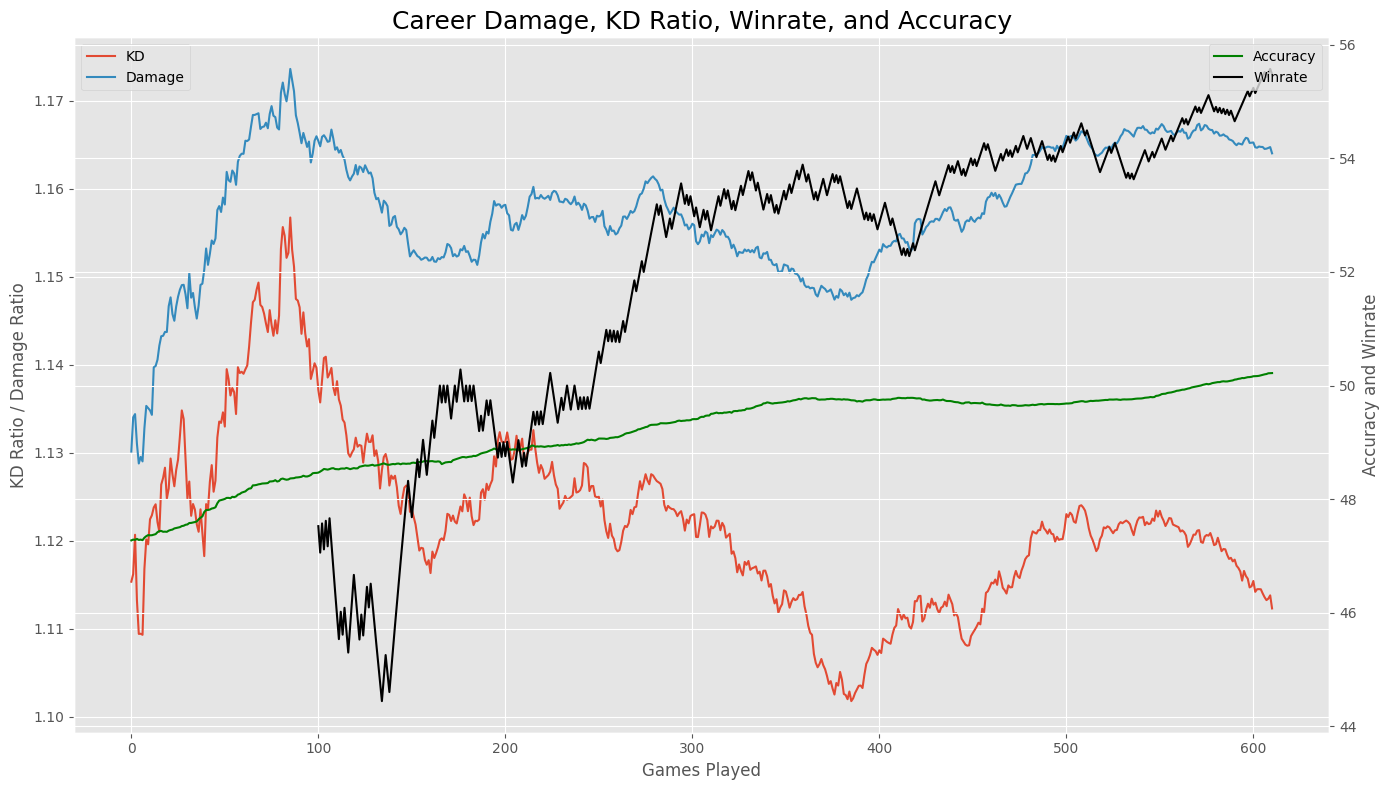

In [9]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax2.plot(dfr['LifetimeWinRate'][100:]*100, color='black', label='Winrate')
ax1.set_title('Career Damage, KD Ratio, Winrate, and Accuracy', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy and Winrate')

ax1.yaxis.grid(True)
ax2.yaxis.grid(True)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDWRAcc.png', dpi=300)
plt.show()

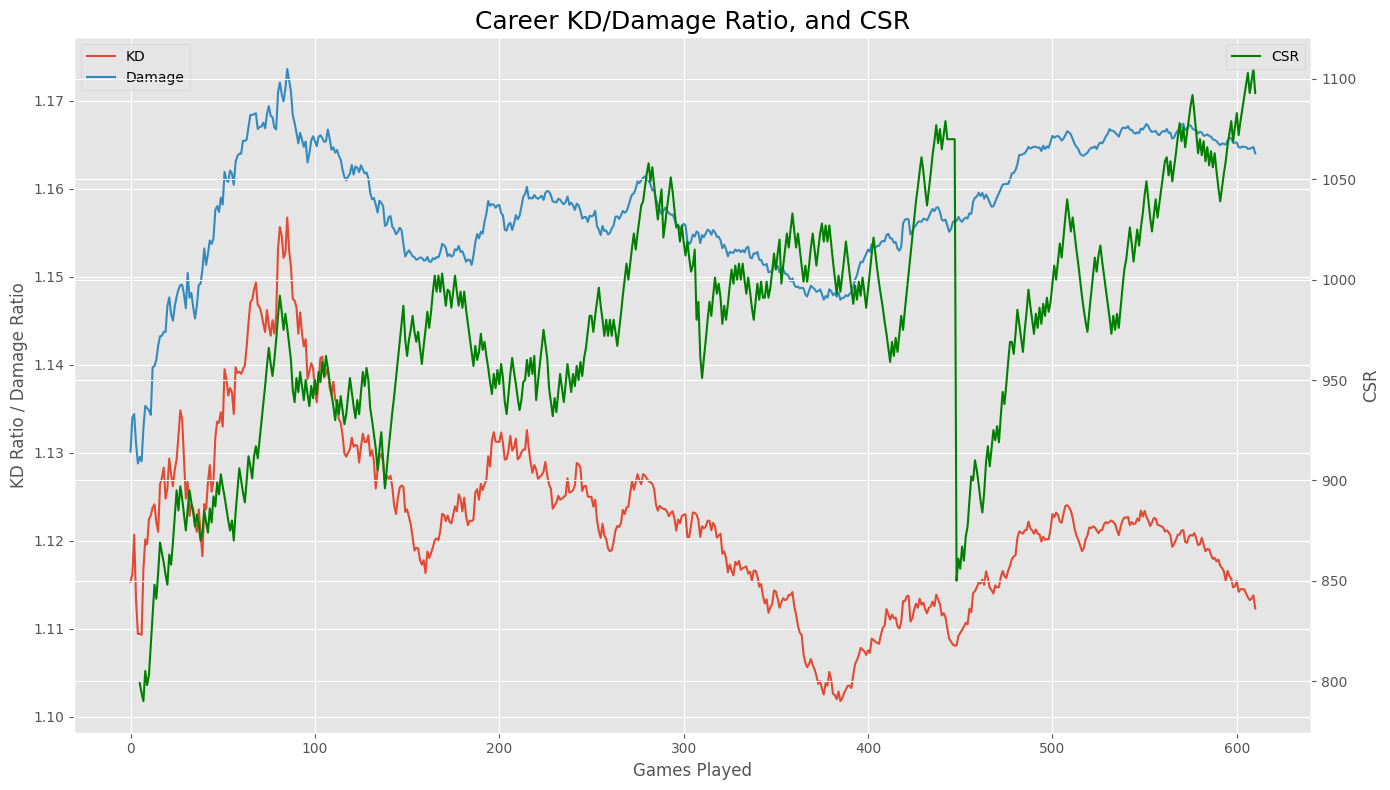

In [10]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'][5:], label='CSR', color='green')
ax1.set_title('Career KD/Damage Ratio, and CSR', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
# ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDCsr.png', dpi=300)
plt.show()

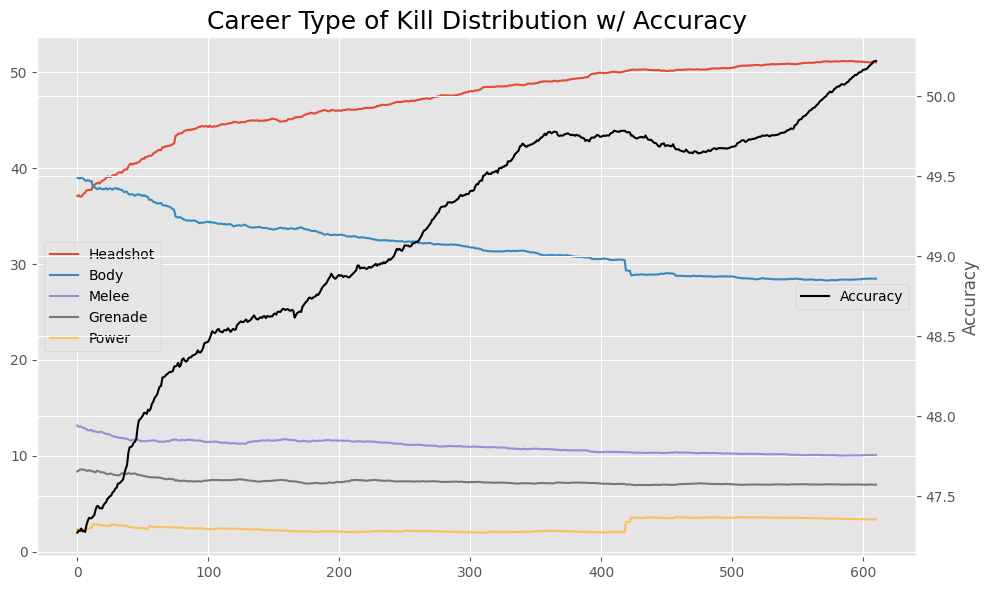

In [11]:
plt.figure(figsize=(10,6))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeHSPct'], label='Headshot')
ax1.plot(dfr['LifetimeBodyPct'], label='Body')
ax1.plot(dfr['LifetimeMeleePct'], label='Melee')
ax1.plot(dfr['LifetimeGrenadePct'], label='Grenade')
ax1.plot(dfr['LifetimePowerPct'], label='Power')
ax2.plot(dfr['LifetimeAcc'], label='Accuracy', color='black')
plt.title('Career Type of Kill Distribution w/ Accuracy', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Accuracy')
ax1.legend(loc='best')
ax2.legend(loc='right')
ax1.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/TypeKillAcc.png', dpi=300)
plt.show()

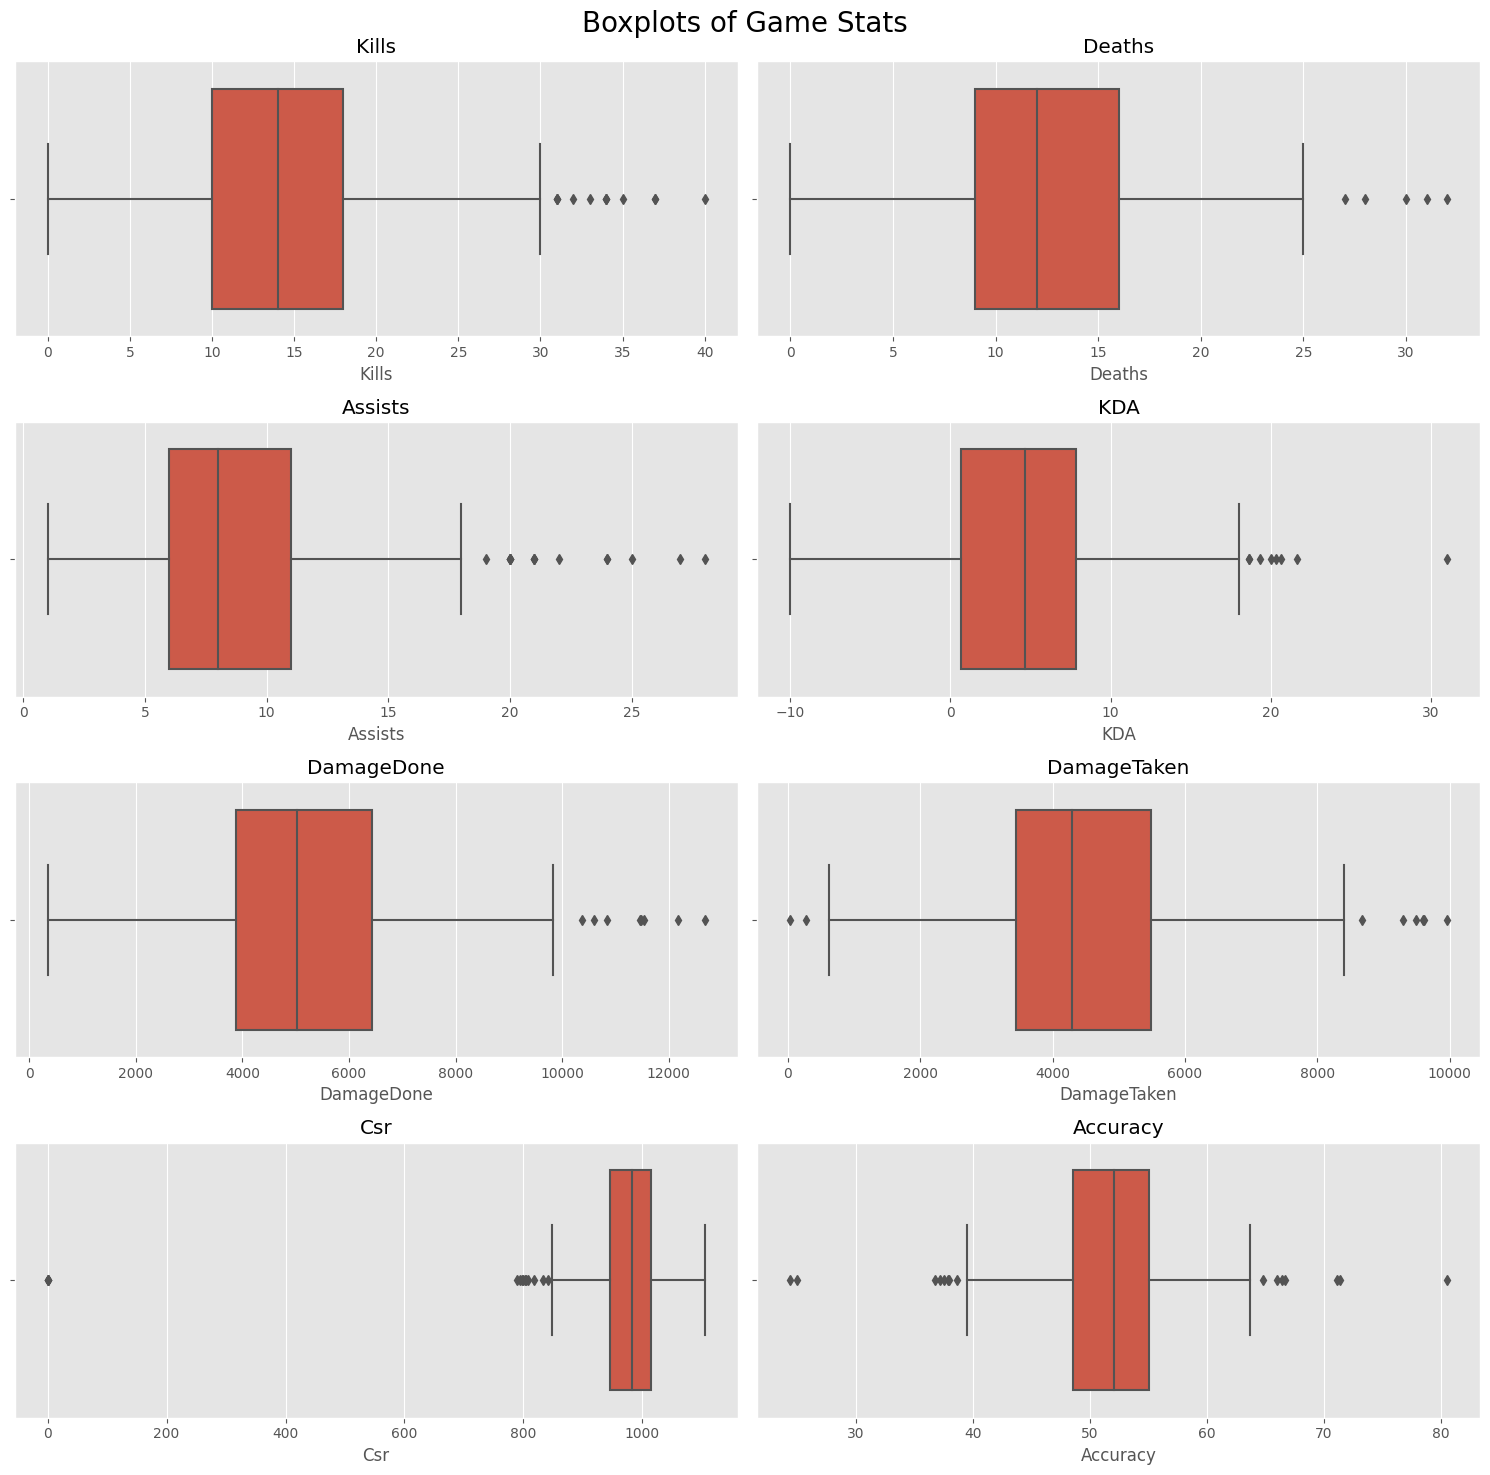

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=20)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


Last * Games stats  
Set mod to however many game you want to view 

In [13]:
# Last * Games

mod = 
dfmod = dfr.tail(mod)

# dfmod = dfr[dfr['DamageTaken'] < dfr['DamageDone']]
# dfmod1 = dfr[dfr['DamageTaken'] > dfr['DamageDone']]

# print(dfmod.head())
print(f'Overall KD: {round(dfmod["Kills"].sum() / dfmod["Deaths"].sum(),2)}')
print(f"Accuracy: {round(dfmod['ShotsLanded'].sum() / dfmod['ShotsFired'].sum()*100,2)}")
print(f"Damage Ratio: {round(dfmod['DamageDone'].sum() / dfmod['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfmod['Outcome']==1).sum()}-{(dfmod['Outcome']==0).sum()}")
print(f"Winrate: {round((dfmod['Outcome']==1).sum() / (dfmod['Outcome']==0).sum() ,2)}")
print(f"Max CSR: {dfmod['Csr'].max()}")
# dfmod.sort_values('Kills', ascending=False).head(10)



Overall KD: 0.86
Accuracy: 57.1
Damage Ratio: 1.07
Win-Loss: 7-3
Winrate: 2.33
Max CSR: 1105


In [14]:
import plotly.express as px

fig = px.line(df, x=df.index, y=df['Accuracy'].rolling(window=20).mean(), 
              labels={'x': 'Number of Games Played', 'y': 'Accuracy'},
              title='Rolling Avg Accuracy')

fig.show()


In [15]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfmod = dfr[dfr['DamageTaken'] < dfr['DamageDone']]
dfmod1 = dfr[dfr['DamageTaken'] > dfr['DamageDone']]

print('Overall')
print(f'Overall KD: {round(dfr["Kills/10Min"].sum() / dfr["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Dmg Done <> Taken: {len(dfmod)}-{len(dfmod1)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Totals')
print(f"Total Games: {dfr.Kills.count()}")
print(f"Total Kills: {dfr.Kills.sum()}")
print(f"Total Deaths: {dfr.Deaths.sum()}")
print(f"Total Assists: {dfr.Assists.sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills/10Min"].sum() / dfw["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills/10Min"].sum() / dfl["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.14
Average Kills: 13.65
Average Deaths: 11.97
Average Assists: 8.08
Average Accuracy: 51.78
Average Damage Done: 5230
Average Damage Taken: 4459
Damage Ratio: 1.17
Dmg Done <> Taken: 476-135
Win-Loss: 339-272
----------------------------
Totals
Total Games: 611
Total Kills: 8879
Total Deaths: 7857
Total Assists: 5219
----------------------------
Wins
Overall KD: 1.32
Average Kills: 14.14
Average Deaths: 10.74
Average Assists: 8.6
Average Accuracy: 52.14
Average Damage Done: 5067
Average Damage Taken: 4103
Damage Ratio: 1.23
Wins: 339
----------------------------
Losses
Overall KD: 0.97
Average Kills: 13.04
Average Deaths: 13.49
Average Assists: 7.42
Average Accuracy: 51.37
Average Damage Done: 5434
Average Damage Taken: 4903
Damage Ratio: 1.11
Losses: 272


In [16]:
# Ranks, 1 = Top Winner, 5 = Top Loser
g1 = dfr[dfr['Rank'] == 1].value_counts().count()
g5 = dfr[dfr['Rank'] == 5].value_counts().count()
g15 = round((g1 + g5) / len(dfr)*100,2)


print('Games Ranked 1:',g1)
print('Games Ranked 5:',g5)
print('MVP %:',g15 )

Games Ranked 1: 125
Games Ranked 5: 138
MVP %: 43.04


## Scorigami
Inspired by NFL, tracks unique statlines and counts if theyve occured before, only shows duplicate records instead of unique

In [17]:
# Create a new column for the combined score in the desired format
dfGami = pd.DataFrame()
dfGami['Kills'] = dfr['Kills']
dfGami['Deaths'] = dfr['Deaths']
dfGami['Assists'] = dfr['Assists']
dfGami['Scorigami'] = dfr['Kills'].astype(str) + '-' + dfr['Deaths'].astype(str) + '-' + dfr['Assists'].astype(str)

# Get unique scorigami scores
scorigami_list = dfGami['Scorigami'].unique()

dfGami = dfGami.sort_values(by=['Kills', 'Deaths', 'Assists'], ascending=False)
# print(dfGami.head())
dfGami.to_csv('Scorigami.csv')

In [18]:
gamiPiv = dfGami.pivot_table(index='Scorigami', aggfunc='size')

gamiPiv = gamiPiv.sort_index()

print("Records with >= 3 Scori:",gamiPiv[gamiPiv.values>2].count())
print(gamiPiv[gamiPiv.values>2].sort_values(ascending=False))


Records with >= 3 Scori: 5
Scorigami
15-8-7      3
19-18-10    3
6-11-8      3
7-12-7      3
8-11-5      3
dtype: int64


In [19]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
round(dfrc.sort_values('Length%', ascending=False),2)

,LengthMinutes,Count,Length%,Count%
Category,,,,
Slayer,1216.62,142,18.96,23.24
Oddball,1112.07,92,17.33,15.06
CTF 3 Captures,1074.43,98,16.74,16.04
Strongholds,1066.22,90,16.61,14.73
King of the Hill,952.52,87,14.84,14.24
Extraction,611.85,70,9.53,11.46
CTF 5 Captures,384.02,32,5.98,5.24


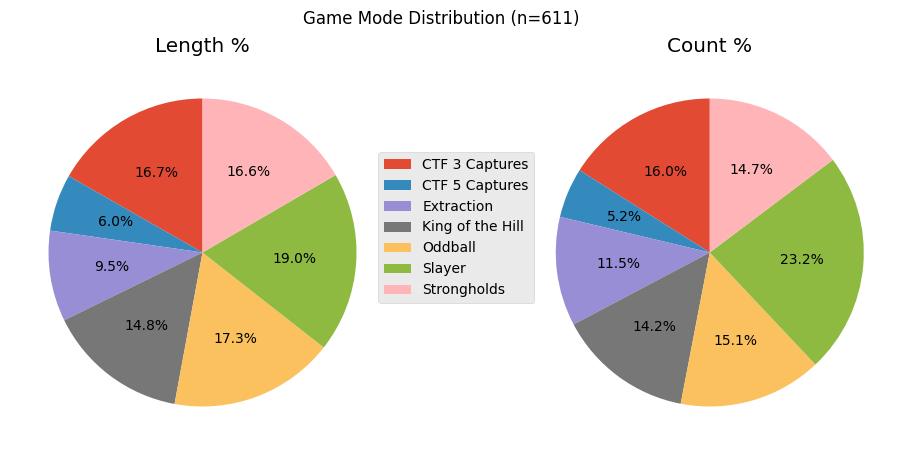

In [20]:
import matplotlib.pyplot as plt

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
fig.suptitle(f'Game Mode Distribution (n={totalcount})')
ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count %')
fig.legend(labels, loc="center")
plt.savefig('Plots/ModeDistro.png', dpi=300)
plt.show()

In [21]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum', 'Outcome': 'mean'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Outcome'] = round(dfrc['Outcome'],2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Length%'], ascending=False)
dfrc

Count  LengthHours  Outcome  Count%  Length%
Category         Map                                                    
Strongholds      Solitude      40         8.36     0.45    6.55     7.82
King of the Hill Recharge      41         7.88     0.51    6.71     7.37
Oddball          Streets       38         7.61     0.63    6.22     7.12
CTF 3 Captures   Empyrean      35         6.66     0.43    5.73     6.23
                 Argyle        34         6.49     0.47    5.56     6.07
CTF 5 Captures   Aquarius      32         6.40     0.47    5.24     5.98
Slayer           Solitude      42         6.16     0.62    6.87     5.76
                 Aquarius      40         5.67     0.57    6.55     5.30
Oddball          Recharge      28         5.55     0.57    4.58     5.19
                 Live Fire     26         5.37     0.62    4.26     5.02
Strongholds      Live Fire     26         4.82     0.54    4.26     4.51
CTF 3 Captures   Forbidden     29         4.76     0.66    4.75     4.45
Extraction       Streets       33         4.74     0.61    5.40     4.43
Strongholds      Recharge      24         4.59     0.42    3.93     4.29
King of the Hill Solitude      22         4.17     0.55    3.60     3.90
                 Live Fire     24         3.82     0.79    3.93     3.57
Slayer           Live Fire     23         3.32     0.57    3.76     3.10
                 Streets       24         3.18     0.62    3.93     2.97
Extraction       Recharge      18         2.76     0.61    2.95     2.58
                 Live Fire     19         2.70     0.42    3.11     2.52
Slayer           Recharge      13         1.94     0.62    2.13     1.81

In [29]:
dfrcc = dfr.groupby(['Category','Map']).agg(
    Count=('Category', 'count'),
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)

dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) * 100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['Dmg/KA'] = dfrcc['DamageDone'] / (dfrcc['Kills'] + dfrcc['Assists'])
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min']
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
dfrcc = round(dfrcc.sort_values(['Winrate', 'Category', 'Map'], ascending=False), 2)
dfrcc

Count  Wins  Losses  Kills  Deaths  Assists  \
Category         Map                                                      
King of the Hill Live Fire     24    19       5    342     321      181   
CTF 3 Captures   Forbidden     29    19      10    382     283      186   
Oddball          Streets       38    24      14    660     591      404   
Slayer           Streets       24    15       9    214     218      162   
                 Solitude      42    26      16    448     446      292   
                 Recharge      13     8       5    125     118       84   
Oddball          Live Fire     26    16      10    412     435      291   
Extraction       Recharge      18    11       7    230     193      143   
                 Streets       33    20      13    453     351      253   
Slayer           Aquarius      40    23      17    416     402      262   
Oddball          Recharge      28    16      12    467     390      297   
Slayer           Live Fire     23    13      10    237     229      132   
King of the Hill Solitude      22    12      10    391     315      226   
Strongholds      Live Fire     26    14      12    414     343      185   
King of the Hill Recharge      41    21      20    702     625      495   
CTF 3 Captures   Argyle        34    16      18    492     436      240   
CTF 5 Captures   Aquarius      32    15      17    604     461      310   
Strongholds      Solitude      40    18      22    771     647      463   
CTF 3 Captures   Empyrean      35    15      20    533     494      265   
Extraction       Live Fire     19     8      11    230     216      125   
Strongholds      Recharge      24    10      14    356     343      223   

                            DamageDone  DamageTaken  Winrate  LengthMinutes  \
Category         Map                                                          
King of the Hill Live Fire      116525       105661     0.79         229.30   
CTF 3 Captures   Forbidden      138082       104192     0.66         285.43   
Oddball          Streets        233123       198613     0.63         456.88   
Slayer           Streets         88763        78925     0.62         190.85   
                 Solitude       173771       158862     0.62         369.72   
                 Recharge        52217        46598     0.62         116.53   
Oddball          Live Fire      159452       139646     0.62         322.12   
Extraction       Recharge        80159        66596     0.61         165.43   
                 Streets        147191       118482     0.61         284.25   
Slayer           Aquarius       164652       146617     0.57         340.22   
Oddball          Recharge       168100       138799     0.57         333.07   
Slayer           Live Fire       86791        81976     0.57         199.30   
King of the Hill Solitude       130584       107965     0.55         250.23   
Strongholds      Live Fire      141389       123367     0.54         289.20   
King of the Hill Recharge       257299       216561     0.51         472.98   
CTF 3 Captures   Argyle         179443       150503     0.47         389.55   
CTF 5 Captures   Aquarius       209780       163115     0.47         384.02   
Strongholds      Solitude       261117       218865     0.45         501.55   
CTF 3 Captures   Empyrean       191519       170612     0.43         399.45   
Extraction       Live Fire       82363        72351     0.42         162.17   
Strongholds      Recharge       133296       116330     0.42         275.47   

                            Accuracy    KD  DamageRatio  Dmg/Life  Dmg/KA  \
Category         Map                                                        
King of the Hill Live Fire     53.94  1.07         1.10    363.01  222.80   
CTF 3 Captures   Forbidden     52.15  1.35         1.33    487.92  243.10   
Oddball          Streets       54.06  1.12         1.17    394.46  219.10   
Slayer           Streets       49.40  0.98         1.12    407.17  236.07   
                 Solit

In [33]:
dfrcc = dfr.groupby('Category').agg(
    Count=('Category', 'count'),
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Wins,Losses,Kills,Deaths,Assists,ShotsLanded,ShotsFired,DamageDone,DamageTaken,Winrate,LengthMinutes,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,,,,,,
Oddball,92,56,36,1539,1416,992,12692,24214,560675,477058,0.61,1112.07,1.09,1.18,395.96,59.05,0.70
Slayer,142,85,57,1440,1413,932,13652,27312,566194,512978,0.60,1216.62,1.02,1.10,400.70,37.66,0.66
King of the Hill,87,52,35,1435,1261,902,11609,22402,504408,430187,0.60,952.52,1.14,1.17,400.01,58.86,0.72
Extraction,70,39,31,913,760,521,7421,13807,309713,257429,0.56,611.85,1.20,1.20,407.52,68.79,0.69
CTF 3 Captures,98,50,48,1407,1213,691,11722,22777,509044,425307,0.51,1074.43,1.16,1.20,419.66,69.03,0.57
CTF 5 Captures,32,15,17,604,461,310,4912,9375,209780,163115,0.47,384.02,1.31,1.29,455.05,101.23,0.67
Strongholds,90,42,48,1541,1333,871,12290,23593,535802,458562,0.47,1066.22,1.16,1.17,401.95,57.94,0.65


In [35]:
dfrcc = dfr.groupby('Map').agg(
    Count=('Category', 'count'),
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Wins,Losses,Kills,Deaths,Assists,ShotsLanded,ShotsFired,DamageDone,DamageTaken,Winrate,LengthMinutes,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,,,,,,
Forbidden,29,19,10,382,283,186,3230,6194,138082,104192,0.66,285.43,1.35,1.33,487.92,119.75,0.66
Streets,95,59,36,1327,1160,819,11143,20983,469077,396020,0.62,931.98,1.14,1.18,404.38,62.98,0.71
Live Fire,118,70,48,1635,1544,914,13303,25078,586520,523001,0.59,1202.08,1.06,1.12,379.87,41.14,0.59
Solitude,104,56,48,1610,1408,981,13156,25358,565472,485692,0.54,1121.50,1.14,1.16,401.61,56.66,0.70
Recharge,124,66,58,1880,1669,1242,16085,32126,691071,584884,0.53,1363.48,1.13,1.18,414.06,63.62,0.74
Aquarius,72,38,34,1020,863,572,8889,17158,374432,309732,0.53,724.23,1.18,1.21,433.87,74.97,0.66
Argyle,34,16,18,492,436,240,4133,8128,179443,150503,0.47,389.55,1.13,1.19,411.57,66.38,0.55
Empyrean,35,15,20,533,494,265,4359,8455,191519,170612,0.43,399.45,1.08,1.12,387.69,42.32,0.54


In [25]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 5.652960374980466s
